## Importamos librerias

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Importamos datos

In [2]:
datos = pd.read_csv('Star99999_raw.csv')

## Los visualizamos

In [3]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  99999 non-null  int64 
 1   Vmag        99999 non-null  object
 2   Plx         99999 non-null  object
 3   e_Plx       99999 non-null  object
 4   B-V         99999 non-null  object
 5   SpType      97377 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.6+ MB


## Pasamos columnas a valores correctos

In [4]:
datos["Vmag"] = pd.to_numeric(datos["Vmag"], downcast="float", errors='coerce')
datos["Plx"] = pd.to_numeric(datos["Plx"], downcast="float", errors='coerce')
datos["e_Plx"] = pd.to_numeric(datos["e_Plx"], downcast="float", errors='coerce')
datos["B-V"] = pd.to_numeric(datos["B-V"], downcast="float", errors='coerce')

In [5]:
datos.describe(include = 'all')

,Unnamed: 0,Vmag,Plx,e_Plx,B-V,SpType
count,99999.000000,99998.000000,99768.000000,99768.000000,98871.000000,97377
unique,NaN,NaN,NaN,NaN,NaN,3756
top,NaN,NaN,NaN,NaN,NaN,K0
freq,NaN,NaN,NaN,NaN,NaN,7355
mean,49999.000000,8.369723,7.212443,1.365389,0.704728,NaN
std,28867.369122,1.313881,11.349038,1.816845,0.489686,NaN
min,0.000000,-1.440000,-54.950001,0.380000,-0.400000,NaN
25%,24999.500000,7.640000,2.510000,0.880000,0.348000,NaN
50%,49999.000000,8.440000,4.630000,1.100000,0.612000,NaN
75%,74998.500000,9.140000,8.410000,1.390000,1.075000,NaN


## Eliminamos la primera columna

In [6]:
datos = datos.drop('Unnamed: 0', axis=1)

## Checamos cuantos datos hay faltantes

In [7]:
faltantes = datos.isnull().sum()
print(faltantes)

Vmag         1
Plx        231
e_Plx      231
B-V       1128
SpType    2622
dtype: int64


In [8]:
total = np.product(datos.shape)
suma_faltantes = faltantes.sum()
print(f'El porcentaje de datos faltantes es: {100*suma_faltantes/total:0.2f} %')

El porcentaje de datos faltantes es: 0.84 %


## Eliminamos renglones con valores faltantes

In [9]:
num_total = datos.shape[0]
datos = datos.dropna()

## Eliminamos renglones donde el error de Plx sea muy grande

In [10]:
threshold = datos['e_Plx'].mean() + 0.75
datos = datos[datos['e_Plx'] < threshold]

num_limpio = datos.shape[0]

In [11]:
print(f'Perdimos el {(1-num_limpio/num_total)*100:0.2f} % del dataset')

Perdimos el 9.87 % del dataset


In [12]:
# Reindexamos
datos = datos.reset_index(drop=True)

## Creamos la columna de magnitud absoluta

In [13]:
datos = datos[datos.Plx != 0]
datos["MagA"] = datos["Vmag"] + 5 * (np.log10(abs(datos["Plx"]))+1)

In [14]:
# Reindexamos
datos = datos.reset_index(drop=True)

## Convertimos SpType a gigante y enana (1 para gigante 0 para enana)

In [15]:
datos['Clase'] = datos['SpType']
for i in range(len(datos['Clase'])):
    if "V" in datos['Clase'].values[i]:
        datos.at[i, 'Clase'] = 0
    elif "I" in datos['Clase'].values[i]:
        datos.at[i, 'Clase'] = 1
    else:
        datos.at[i, 'Clase'] = 2
datos = datos[datos.Clase != 2]
datos['Clase'] = pd.to_numeric(datos['Clase'], downcast="float")

In [16]:
datos = datos.drop(['e_Plx', 'SpType'], axis=1)

In [17]:
# Reindexamos
datos = datos.reset_index(drop=True)

## Valanceamos los datos

In [18]:
enanas = datos[datos.Clase == 0]
gigantes = datos[datos.Clase == 1]
print(f'Tenemos {enanas.shape[0]} estrellas enanas y {gigantes.shape[0]} estrellas gigantes')

Tenemos 26071 estrellas enanas y 19415 estrellas gigantes


Tenemos mas estrellas enanas que gigantes hay que valancear eso

In [19]:
enanas = resample(enanas, replace=False, n_samples=gigantes.shape[0])
datos = pd.concat([gigantes, enanas])
datos = datos.sample(frac=1).reset_index(drop=True)

## Volvemos a ver los datos

In [20]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38830 entries, 0 to 38829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Vmag    38830 non-null  float32
 1   Plx     38830 non-null  float32
 2   B-V     38830 non-null  float32
 3   MagA    38830 non-null  float32
 4   Clase   38830 non-null  float32
dtypes: float32(5)
memory usage: 758.5 KB


In [21]:
datos.describe()

,Vmag,Plx,B-V,MagA,Clase
count,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000
mean,7.873541,7.020456,0.739088,15.993328,0.500000
std,1.288882,11.258369,0.516208,2.390976,0.500006
min,-0.620000,-6.680000,-0.400000,-0.350000,0.000000
25%,7.160000,2.430000,0.344000,14.732005,0.000000
50%,8.120000,4.420000,0.696000,15.987060,0.500000
75%,8.790000,8.197500,1.125750,17.510725,1.000000
max,11.580000,742.119995,3.440000,28.004795,1.000000


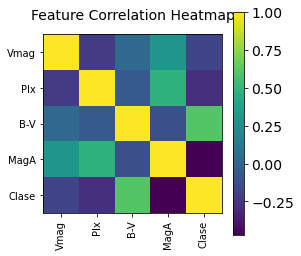

In [22]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=10, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=10)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(datos)

## Guardamos el dataset

In [23]:
datos.to_csv("CleanStar.csv", index=False)